In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#Get sample pathogenic RNA-seq data
!wget -o - "http://mcb112.org/w04/pathogen.fa" > "output.txt"

In [3]:
#Get sample non-pathogenic (fictional sandmouse) RNA-seq data
!wget -o - "http://mcb112.org/w04/sandmouse.fa" > "output.txt"

In [4]:
!wget -o - "http://mcb112.org/w04/moriarty-neg.fa" > "output.txt"

# Problem 1

In this project, I seek to differentiate between sample RNA seq data from a fictional 'sandmouse' which contains genomic regions corresponding to pathogenic sequences, and RNA seq data that corresponds to a healthy sandmouse.

In order to do so, I calculate the probabilities of single, double, and triple base combinations as found in healthy and pathogenic RNA-seq data, and then implement a second-order markov model from first principles to find the maximally likely classification of RNA-seq reads as pathogenic or healthy. Finally, I explore how effective my model woudl be in the field.


In [5]:
with open('pathogen.fa', 'r') as f:
    pathogen = []
    for line in f:
        if line[0] != ">":
            pathogen.append(line)

In [6]:
with open('sandmouse.fa', 'r') as f:
    sandmouse = []
    for line in f:
        if line[0] != ">":
            sandmouse.append(line)

In [7]:
with open('moriarty-neg.fa', 'r') as f:
    random = []
    for line in f:
        if line[0] != ">":
            random.append(line)

In [11]:
#stores single, double, and triple nucleotide combinations as keys in dict
bases = ['A', 'C', 'G', 'T']
keys = []
for base in bases:
    keys.append(base)
    temp1 = base
    for base1 in bases:
        keys.append(temp1+base1)
        temp2 = temp1 + base1
        for base2 in bases:
            keys.append(temp2+base2)
pathogen_tallies = dict.fromkeys(keys, 0)
sandmouse_tallies = dict.fromkeys(keys, 0)

In [12]:
#Tallies the total each single nucleotide, double nucleotide, and triple nucleotide combinations found in the pathogen sequences. 
#For this training stage, the first half of the data sets is used (testing done using the second half).
with open('pathogen.fa', 'r') as f: 
    counter = 0
    for line in f:
        counter += 1
    first_half=counter/2
f.close()
with open('pathogen.fa', 'r') as f:
    k = 0
    for line in f:
        k += 1
        if k >= first_half:
            break
        if line[0] == ">":
            continue
        for i in range(len(line)-1): # take care of the \n symbol at the end of each line
            pathogen_tallies[line[i]] += 1
            if i < (len(line)-2): #store the tallies of two-base pair combinations 
                double = line[i] + line[i+1]
                pathogen_tallies[double] +=1
            if i < (len(line)-3): #store the tallies of three-base combinations
                triple = line[i] + line[i+1] + line[i+2]
                pathogen_tallies[triple] += 1

In [13]:
#Tallies the total each single nucleotide, double nucleotide, and triple nucleotide combinations 
#found in the non-pathogen (sandmouse) sequences.
with open('sandmouse.fa', 'r') as f:
    m = 0
    for line in f:
        m += 1
        if m >= first_half:
            break
        if line[0] == ">":
            continue
        for i in range(len(line)-1):
            sandmouse_tallies[line[i]] += 1
            if i < (len(line)-2):
                double = line[i] + line[i+1]
                sandmouse_tallies[double] +=1
            if i < (len(line)-3):
                triple = line[i] + line[i+1] + line[i+2]
                sandmouse_tallies[triple] += 1

Here, I find the probability of finding each of the single base, two-base, and three-base combinations in the pathogen sequences, and then again in the non-pathogen (sandmouse) sequences. In the case of two-base combinations, I find the probability of finding each two-base combination given the presence of a first base, and for the three base combinations, I find the probability of finding each combination given the presence of two initial bases. In this way, the probabilities of each combination with given starting bases add to 1.

In [14]:
first_sum = 0
pathogen_probs = dict.fromkeys(keys, 0)
sandmouse_probs = dict.fromkeys(keys, 0)

for key in pathogen_tallies:
    if len(key) == 1:
        first_sum += pathogen_tallies[key]
for base in bases:
    pathogen_probs[base] = pathogen_tallies[base]/first_sum #store probability of each of the four bases
    for base1 in bases:
        second_sum = 0
        for key2 in pathogen_tallies: #calculate the sum of two-position base combinations starting with same first base
            if (len(key2) == 2) & (key2.startswith(base)):
                second_sum += pathogen_tallies[key2]
        pathogen_probs[base+base1] = pathogen_tallies[base+base1]/second_sum #store probability of the combination base-base1
        temp = base + base1
        for base2 in bases:
            third_sum = 0
            for key3 in pathogen_tallies: #calculate the sum of the second position ones
                if (len(key3) == 3) & (key3.startswith(temp)): #find keys corresponding to the two prior bases
                    third_sum += pathogen_tallies[key3]
            pathogen_probs[temp+base2] = pathogen_tallies[temp+base2]/third_sum #store probability of base-base1-base2

In [15]:
first_sum = 0
for key in sandmouse_tallies:
    if len(key) == 1:
        first_sum += sandmouse_tallies[key]
for base in bases:
    sandmouse_probs[base] = sandmouse_tallies[base]/first_sum #store probability of each of the four bases
    for base1 in bases:
        second_sum = 0
        for key in sandmouse_tallies: #calculate the sum of two-position base combinations starting with same first base
            if (len(key) == 2) & (key.startswith(base)):
                second_sum += sandmouse_tallies[key]
        sandmouse_probs[base + base1] = sandmouse_tallies[base+base1]/second_sum #store probability of the combination base-base1
        temp = base + base1
        for base2 in bases:
            third_sum = 0
            for key in sandmouse_tallies: #calculate the sum of the second position ones
                if (len(key) == 3) & (key.startswith(temp)): #find keys corresponding to the two prior bases
                    third_sum += sandmouse_tallies[key]
            sandmouse_probs[temp+base2] = sandmouse_tallies[temp+base2]/third_sum #store probability of base-base1-base2

Next, I store the log of the probabilities for both sandmouse and pathogen sequences that I calculated.

In [16]:
pathogen_logs = dict.fromkeys(keys, 0)
sandmouse_logs = dict.fromkeys(keys, 0)

for key in pathogen_probs:
    pathogen_logs[key] = np.log10(pathogen_probs[key])
    sandmouse_logs[key] = np.log10(sandmouse_probs[key])

Next, I generate my log odds score for the sandmouse data using a second order Markov model. For this test, I calculate the log odds score of the non-pathogenic (sandmouse) data given the pathogen probabilities over the sandmouse probabilities. Given this, we expect the values of the log odds score to be negative here because it should be more likely to find this data given our sandmouse probabilities.

In [17]:
with open('sandmouse.fa', 'r') as f:
    m = 0
    sandmouse_test = []
    for line in f:
        p_path = 0
        p_sand = 0
        m += 1
        if m < first_half:
            continue
        if line[0] == ">":
            continue
        p_path = pathogen_logs[line[0]+line[1]]
        p_sand = sandmouse_logs[line[0]+line[1]]
        for i in range(2, len(line)-1):
            p_path = p_path + pathogen_logs[line[i-2]+line[i-1]+line[i]]
            p_sand = p_sand + sandmouse_logs[line[i-2]+line[i-1]+line[i]]
        sandmouse_test.append(p_path-p_sand)
    f.close()

We can check to make sure the sandmouse_test values are generally negative by looking at the first few values.

In [18]:
print(sandmouse_test[0:10])

[-4.057431145249836, -0.20763750333404118, -0.3834628274126999, -1.7926098840404165, -0.7686031676627181, -0.5598811542548248, -2.3006084152212907, -0.4958445977585768, -1.915822717793617, -1.8233173042268334]


Now, I repeat the process of calculating log odds scores for the pathogen data. Again, I calculate the log odds score of the data given the pathogen probabilities over the sandmouse probabilities. Given this, we expect the values of the log odds to be postitive here because it should be more likely to find this data given our pathogen probabilities.

In [19]:
with open('pathogen.fa', 'r') as g:
    m = 0
    pathogen_test = []
    for line in g:
        m += 1
        if m < first_half:
            continue
        if line[0] == ">":
            continue
        p_path = pathogen_logs[line[0]+line[1]]
        p_sand = sandmouse_logs[line[0]+line[1]]
        for i in range(2, len(line)-1):
            p_path = p_path + pathogen_logs[line[i-2]+line[i-1]+line[i]]
            p_sand = p_sand + sandmouse_logs[line[i-2]+line[i-1]+line[i]]
        pathogen_test.append(p_path-p_sand)
    g.close()

We can check to make sure the pathogen_test values are generally positive by looking at the first few values.

In [20]:
print(pathogen_test[0:10])

[1.9775199163632635, 1.5386781456810894, 1.2151706298332812, 2.015097172845344, 1.3884625395552206, 2.4263717332294306, -1.2803472852007474, 4.5578594664179235, 2.0519705253487217, 0.23978280429422227]


Having calculated the log odds scores for the two sequence sets, I can now plot them in a histogram. If my model is sucessful in distinguishing sequences from pathogen and non-pathogen (sandmouse), there will be two clearly separate distributions, with minimal overlap.

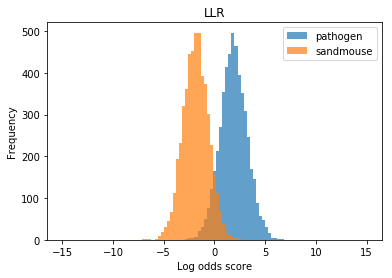

In [21]:
fig2 = plt.subplots(1,1)
fig_bins2 = np.linspace(-15, 15, 100)
pathogen = plt.hist(pathogen_test, bins = fig_bins2, alpha=0.7, label='pathogen')
sandmouse = plt.hist(sandmouse_test, bins = fig_bins2, alpha=0.7, label = 'sandmouse')
plt.ylabel('Frequency')
plt.xlabel('Log odds score')
plt.legend(loc='upper right')
plt.title('LLR')
plt.show()

The histogram above shows that indeed, the log odds scores generated using our second order Markov model with our sequence data from the two sources can fairly well distinguish between pathogen and sandmouse. In order to formalize how well we can distinguish between the two, and in order to pinpoint the ideal threshold value we should utilize to achieve our desired sensitivity, I generate a ROC plot below showing sensitivity against the false positive rate.

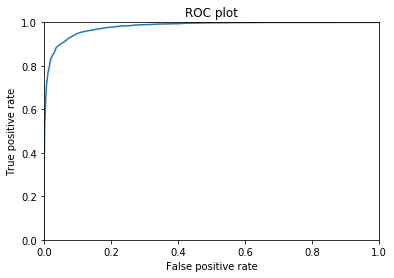

In [22]:
thresholds = np.linspace(min(sandmouse_test+pathogen_test), max(sandmouse_test+pathogen_test), 500)
tp_rates1 = []
fp_rates1 = []

tp_plus_fn1 = len(pathogen_test)
fp_plus_tn1 = len(sandmouse_test)
threshold_found = True

for threshold in thresholds:
    tp = 0
    for i in range(len(pathogen_test)):
        if pathogen_test[i] > threshold:
            tp += 1
    tp_rates1.append(tp/tp_plus_fn1)
    fp = 0
    for k in range(len(sandmouse_test)):
        if sandmouse_test[k] > threshold:
            fp += 1
    fp_rates1.append(fp/fp_plus_tn1)
    if (tp/tp_plus_fn1 < 0.9) & (threshold_found == True): #stores the threshold value at which we find 90% sensitivity
        desired_threshold = threshold
        fpr = fp/fp_plus_tn1
        threshold_found = False
        
plt.plot(fp_rates1, tp_rates1)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('ROC plot')
plt.show()

This ROC plot shows that for a very low false positive rate, we can achieve a high true positive rate. This indicates that our second-order Markov model seems generally effective in separating between pathogen and sandmouse sequence sets. However, in order to more thoroughly understand how our model would perform in the field, I explore how threshold values would correspond to specificity rates and FDR.

In [23]:
print('The threshold value that would give us 90 percent specificity is %.2f' %(desired_threshold))

The threshold value that would give us 90 percent specificity is 0.20


In [24]:
print('The false positive rate at this threshold value is %.4f, or %.2f percent' %(fpr, fpr*100))

The false positive rate at this threshold value is 0.0478, or 4.78 percent


In order to find these values, I simply stored the values of the threshold corresponding to the desired specificity and resulting false positive rate during the ROC plot generation step. As such, it may be a good idea to write a short amount of code to check that these values are indeed correct. To do so, we can iterate through the results of our tests, and do a simple calculation to see the proportion of pathogen_test and sandmouse_test that are above the threshold rate we calculated.  

In [25]:
path_counter = 0
sand_counter = 0

for i in range(len(pathogen_test)):
    if pathogen_test[i] > desired_threshold:
        path_counter += 1
    if sandmouse_test[i] > desired_threshold:
        sand_counter += 1

check_sens = path_counter/len(pathogen_test)
check_fpr = sand_counter/len(sandmouse_test)

print("Our double-checked values for sensitivity and false-positive rate at this threshold are %.1f and %.4f."%(check_sens, check_fpr))

Our double-checked values for sensitivity and false-positive rate at this threshold are 0.9 and 0.0478.


Looks like our threshold was correct, as using it we were able to reproduce our sensitivity and fpr values. 

On first glance, having a false positive rate of 4.78% seems quite good. After all, this means that about 95% of negatives are correctly classified! However, when applied in the field, having a specificity of about 95% (FPR of 4.78%) would actually be quite problematic. The reason is that, since the vast majority of reads (in our case, 99%) are sand mouse reads, even if we label 5% of them as pathogen, this number will dwarf the number of true positives from the 1% of actual pathogen reads we get. In order to formalize this intuition, we can simulate the calculation of the FDR, which would show us the number of false positives divided by all positives.

In [26]:
#FDR simulated calculation:
reads = 100000
preads = reads*0.01
sreads = reads*0.99
true_pos = 0.9*preads
false_pos = fpr*sreads
fdr = false_pos/(true_pos + false_pos)
print('The false discovery rate using our given sensitivity and false positive rate would be %.2f percent' % (fdr*100))

The false discovery rate using our given sensitivity and false positive rate would be 84.02 percent


This means that, of all of the reads we detect as 'pathogen', about 84% of them will actually be sandmouse! As we can see, this actually wouldn't be a very effective way of detecting pathogen reads. We can confirm our results by seeing how this would actually play out if we ran our Markov model on our data again, but this time using a ratio of 99 mouse sequences to 1 pathogen sequence. In order to do this, I randomly sample 1% of the log odds scores from the pathogen test data and 99% of the log odds scores from the sandmouse data. Then, I plot a histogram in the same way as done above. Using the same threshold, we should see roughly the same sensitivity and specificity, and moreover should see an FDR of 84% in our simulation.

In [27]:
pathogen_simulation = np.random.choice(pathogen_test, int(math.floor(len(pathogen_test)/100)))
sandmouse_simulation = np.random.choice(sandmouse_test, 99*int(math.floor(len(sandmouse_test)/100)))

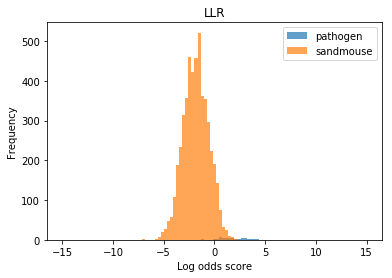

In [28]:
fig3 = plt.subplots(1,1)
fig_bins3 = np.linspace(-15, 15, 100)
pathogen = plt.hist(pathogen_simulation, bins = fig_bins3, alpha=0.7, label='pathogen')
sandmouse = plt.hist(sandmouse_simulation, bins = fig_bins3, alpha=0.7, label = 'sandmouse')
plt.ylabel('Frequency')
plt.xlabel('Log odds score')
plt.legend(loc='upper right')
plt.title('LLR')
plt.show()

As we can see, even though there is still some perceptible difference between where the data  from the pathogen and the sandmouse generally fall, because the sandmouse is overall sampled so much more than the pathogen, we can visually see that there is a significant amount of orange covering blue, implying that there will be a high number of false positivies for every true positive. We can formalize this initial intuition by calculating the FDR. 

In [29]:
path_counter = 0
sand_counter = 0
for i in range(len(pathogen_simulation)):
    if pathogen_simulation[i] > desired_threshold:
        path_counter += 1
for k in range(len(sandmouse_simulation)):
    if sandmouse_simulation[k] > desired_threshold:
        sand_counter += 1
sim_sens = path_counter/len(pathogen_simulation)
sim_fpr = sand_counter/len(sandmouse_simulation)

print("The values for sensitivity and false positive rate at our calculated threshold are %.1f and %.4f." %(sim_sens, sim_fpr))


The values for sensitivity and false positive rate at our calculated threshold are 1.0 and 0.0535.


As we expected, our sensitivity and specificity values are roughly the same as they were using when we ran our initial test. (These values will change slightly given that they are based on a random sampling of the log odds scores, but in general will hover around 0.9 and 0.0478). Now we can check to see if indeed the FDR is around 84%, as expected.

In [30]:
fdr_sim = sand_counter/(path_counter+sand_counter)
print("The false discovery rate is %.1f percent"% (fdr_sim*100))

The false discovery rate is 84.7 percent


This shows that our initial calculations were correct. In this simulated experiment, we confirm our initial calculation that the FDR would be unacceptably high in the field given the proportions of pathogen to sandmouse DNA found in nature. Thus, we would need to make adjustments to our method in order to increase our specificity, leading to a decrease in the FDR and making the results we label 'pathogen' more trustworthy. One way we could do this is lowering the desired sensitivity. If the lab does need a 90% sensitivity, this may be not be a valid option; however, it still is worth checking to see what effect lowering the needed sensitivity by even a small amount would have on our threshold and FPR. Below, I calculate what our values would come out to be with a desired senstivity of 80%. 

In [31]:
newlist = list(sandmouse_simulation)+list(pathogen_simulation)
thresholds = np.linspace(min(newlist), max(newlist), 500)

tp_plus_fn2 = len(pathogen_simulation)
fp_plus_tn2 = len(sandmouse_simulation)

threshold_found = True
for threshold in thresholds:
    tp = 0
    for i in range(len(pathogen_simulation)):
        if pathogen_simulation[i] > threshold:
            tp += 1
    fp = 0
    for k in range(len(sandmouse_simulation)):
        if sandmouse_simulation[k] > threshold:
            fp += 1
    if (tp/tp_plus_fn2 < 0.8) & (threshold_found == True):
        desired_threshold1 = threshold
        fpr = fp/fp_plus_tn2
        threshold_found = False
print('If we lower our bar for sensitivity to 80 percent, the threshold we would need is %.2f'%(desired_threshold1))

If we lower our bar for sensitivity to 80 percent, the threshold we would need is 0.69


With this new threshold, let's confirm that our sensitivity is at 80%, and calculate what the FPR and FDR would be.

In [32]:
path_counter = 0
sand_counter = 0
for i in range(len(pathogen_simulation)):
    if pathogen_simulation[i] > desired_threshold1:
        path_counter += 1
for k in range(len(sandmouse_simulation)):
    if sandmouse_simulation[k] > desired_threshold1:
        sand_counter += 1
sim_sens1 = path_counter/len(pathogen_simulation)
sim_fpr1 = sand_counter/len(sandmouse_simulation)

fdr_sim1 = sand_counter/(path_counter+sand_counter)

print("The values for sensitivity and false positive rate at our new threshold are %.1f and %.4f."%(sim_sens1, sim_fpr1))
print("The false discovery rate would be %.1f percent"% (fdr_sim1*100))


The values for sensitivity and false positive rate at our new threshold are 0.8 and 0.0178.
The false discovery rate would be 69.3 percent


By lowering our sensitivity threshold to 80%, our FDR remains quite high. This new FDR is still not ideal, becasue the majority of reads labeled 'pathogen' would still come from sandmouse DNA. However, lowering the sensitivity threshold even more might not be a good idea, since it would lead to a significant loss of data from the (relatively rare) pathogen DNA, and the resulting decrease in FDR may not be worth it. So, if we wanted to improve our results, we should instead start thinking of other ways to improve our model. One way we could do this, for example, is developing a different Markov model. In the future, for example, I would consider developing a third-order Markov model to see if this would allow us to distinguish between sandmouse and pathogen data more effectively in the field. 